# Read data

In [60]:
import pandas as pd
import datetime

# Lese die all_activities.csv ein
activity_cols = {
    "Datum": "date",
    "Aktivitätstyp": "activity_type",
    "Distanz": "distance",
    "Ø Pace": "pace_average",
    "Kalorien": "calories",
    "Zeit": "time",
    "Ø Herzfrequenz": "heart_rate_average",
    "Ø Leistung": "cadence_average",
    "Ø Atemfrequenz": "respiration_rate_average",
}
df_activities = pd.read_csv(
    "data/raw/all_activities.csv",
    usecols=list(activity_cols.keys())
)
df_activities.rename(columns=activity_cols, inplace=True)

sleep_cols = {
    "Sleep Score 7 Tage": "date",
    "Score": "score",
    "Qualitaet": "quality",
    "Dauer": "duration",
    "Schlafenszeit": "bedtime",
    "Ruheherzfrequenz": "resting_heart_rate",
    "Body Battery": "body_battery",
    "Atmung": "respiration_rate",
    "HFV-Status": "hrv_status",
}
df_sleep = pd.read_csv(
    "data/raw/sleep.csv",
    usecols=list(sleep_cols.keys())
)
df_sleep.rename(columns=sleep_cols, inplace=True)


In [61]:
df_activities.head()

activity_type                 date distance calories      time  \
0                Laufen  2025-09-21 09:53:57    42.65    2,817  04:35:15   
1                Laufen  2025-09-20 15:18:50     3.72      246  00:20:13   
2  Virtuelles Radfahren  2025-09-19 12:31:00    12.81      210  00:30:18   
3                Laufen  2025-09-15 11:16:13     5.60      350  00:30:39   
4                Laufen  2025-09-13 10:51:36     9.01      549  00:44:56   

  heart_rate_average pace_average cadence_average respiration_rate_average  
0                148         6:27             251                       30  
1                144         5:26             303                       30  
2                116         25.4             120                       --  
3                133         5:28             297                       26  
4                144         4:59             326                       32

In [62]:
df_sleep.head()

date score resting_heart_rate body_battery respiration_rate  \
0  2025-09-30    77                 44           55            11.38   
1  2025-09-29    73                 46           62               12   
2  2025-09-28    34                 47           21            14.96   
3  2025-09-27    93                 41           67            11.13   
4  2025-09-26    97                 42           71            11.15   

  hrv_status        quality  duration   bedtime  
0         83    Ausreichend  6h 47min  11:22 PM  
1         84    Ausreichend   9h 6min  10:52 PM  
2         84       Schlecht  6h 34min  12:34 AM  
3         92  Ausgezeichnet  8h 32min  10:39 PM  
4         90  Ausgezeichnet  7h 50min  10:07 PM

# Clean data/time features

In [63]:

def pace_to_seconds(pace_str):
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            parts = pace_str.split(":")
            if len(parts) == 2:
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:  # If format is HH:MM:SS
                hours, minutes, seconds = int(
                    parts[0]), int(parts[1]), int(parts[2])
                return hours * 3600 + minutes * 60 + seconds
        return float(pace_str)
    except Exception:
        return 0


# activities
date = pd.to_datetime(df_activities["date"], errors="coerce")
df_activities["date"] = date.dt.date
df_activities['date'] = pd.to_datetime(df_activities['date'], errors='coerce')
df_activities["time"] = date.dt.time
df_activities["time_seconds"] = df_activities["time"].apply(
    lambda t: t.hour * 3600 + t.minute * 60 +
    t.second if hasattr(t, "hour") else 0
)

df_activities["pace_average"] = df_activities["pace_average"].apply(
    pace_to_seconds)

df_activities.head()

activity_type       date distance calories      time  \
0                Laufen 2025-09-21    42.65    2,817  09:53:57   
1                Laufen 2025-09-20     3.72      246  15:18:50   
2  Virtuelles Radfahren 2025-09-19    12.81      210  12:31:00   
3                Laufen 2025-09-15     5.60      350  11:16:13   
4                Laufen 2025-09-13     9.01      549  10:51:36   

  heart_rate_average  pace_average cadence_average respiration_rate_average  \
0                148         387.0             251                       30   
1                144         326.0             303                       30   
2                116          25.4             120                       --   
3                133         328.0             297                       26   
4                144         299.0             326                       32   

   time_seconds  
0         35637  
1         55130  
2         45060  
3         40573  
4         39096

In [64]:

df_activities['activity_type'] = df_activities['activity_type'].replace({
    'Virtuelles Radfahren': 'Fahrrad',
    'Rennradfahren': 'Fahrrad',
    'Indoor Cycling': 'Fahrrad',
    'Laufbandtraining': 'Laufen',
})

numeric_columns = [
    "calories",
    "distance",
    "heart_rate_average",
    "cadence_average",
    "respiration_rate_average",
    "pace_average",
    "time_seconds",
]

# Konvertiere die ausgewählten Spalten zu numerisch, nur wenn sie vom Typ object sind
for col in numeric_columns:
    if df_activities[col].dtype == "object":
        df_activities[col] = pd.to_numeric(df_activities[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_activities[col] = pd.to_numeric(df_activities[col], errors='coerce')
df_activities['activity_code'] = df_activities['activity_type'].astype('category').cat.codes

df_activities.head()

activity_type       date  distance  calories      time  heart_rate_average  \
0        Laufen 2025-09-21     42.65      2817  09:53:57                 148   
1        Laufen 2025-09-20      3.72       246  15:18:50                 144   
2       Fahrrad 2025-09-19     12.81       210  12:31:00                 116   
3        Laufen 2025-09-15      5.60       350  11:16:13                 133   
4        Laufen 2025-09-13      9.01       549  10:51:36                 144   

   pace_average  cadence_average  respiration_rate_average  time_seconds  \
0         387.0              251                        30         35637   
1         326.0              303                        30         55130   
2          25.4              120                         0         45060   
3         328.0              297                        26         40573   
4         299.0              326                        32         39096   

   activity_code  
0              6  
1              6  
2              3  
3              6  
4              6

In [65]:
df_activities.dtypes

activity_type                       object
date                        datetime64[ns]
distance                           float64
calories                             int64
time                                object
heart_rate_average                   int64
pace_average                       float64
cadence_average                      int64
respiration_rate_average             int64
time_seconds                         int64
activity_code                         int8
dtype: object

In [66]:
def bedtime_to_seconds(bedtime_str):
    try:
        t = pd.to_datetime(bedtime_str, format="%I:%M %p", errors="coerce")
        if pd.isnull(t):
            return 0
        return t.hour * 3600 + t.minute * 60 + t.second
    except Exception:
        return 0

df_sleep["bedtime_seconds"] = df_sleep["bedtime"].apply(bedtime_to_seconds)

df_sleep["date"] = pd.to_datetime(df_sleep["date"], errors="coerce")

df_sleep["duration"] = pd.to_timedelta(df_sleep["duration"], errors="coerce")
df_sleep["duration_seconds"] = (
    df_sleep["duration"].dt.total_seconds().fillna(0).astype(int)
)

In [67]:
# Definiere die Spalten, die sinnvollerweise numerisch sind
numeric_columns = [
    "score",
    "duration_seconds",
    "bedtime_seconds",
    "resting_heart_rate",
    "body_battery",
    "respiration_rate",
    "hrv_status"
]

df_sleep['quality_code'] = df_sleep['quality'].astype('category').cat.codes

# Konvertiere die ausgewählten Spalten zu numerisch, nur wenn sie vom Typ object sind
for col in numeric_columns:
    if df_sleep[col].dtype == "object":
        df_sleep[col] = pd.to_numeric(df_sleep[col].str.replace(',', '').replace('--', '0'), errors='coerce')
    else:
        df_sleep[col] = pd.to_numeric(df_sleep[col], errors='coerce')


df_sleep.head()

date  score  resting_heart_rate  body_battery  respiration_rate  \
0 2025-09-30     77                  44            55             11.38   
1 2025-09-29     73                  46            62             12.00   
2 2025-09-28     34                  47            21             14.96   
3 2025-09-27     93                  41            67             11.13   
4 2025-09-26     97                  42            71             11.15   

   hrv_status        quality        duration   bedtime  bedtime_seconds  \
0          83    Ausreichend 0 days 06:47:00  11:22 PM            84120   
1          84    Ausreichend 0 days 09:06:00  10:52 PM            82320   
2          84       Schlecht 0 days 06:34:00  12:34 AM             2040   
3          92  Ausgezeichnet 0 days 08:32:00  10:39 PM            81540   
4          90  Ausgezeichnet 0 days 07:50:00  10:07 PM            79620   

   duration_seconds  quality_code  
0             24420             2  
1             32760             2  
2             23640             4  
3             30720             1  
4             28200             1

# Corelation Matrix sleep after training

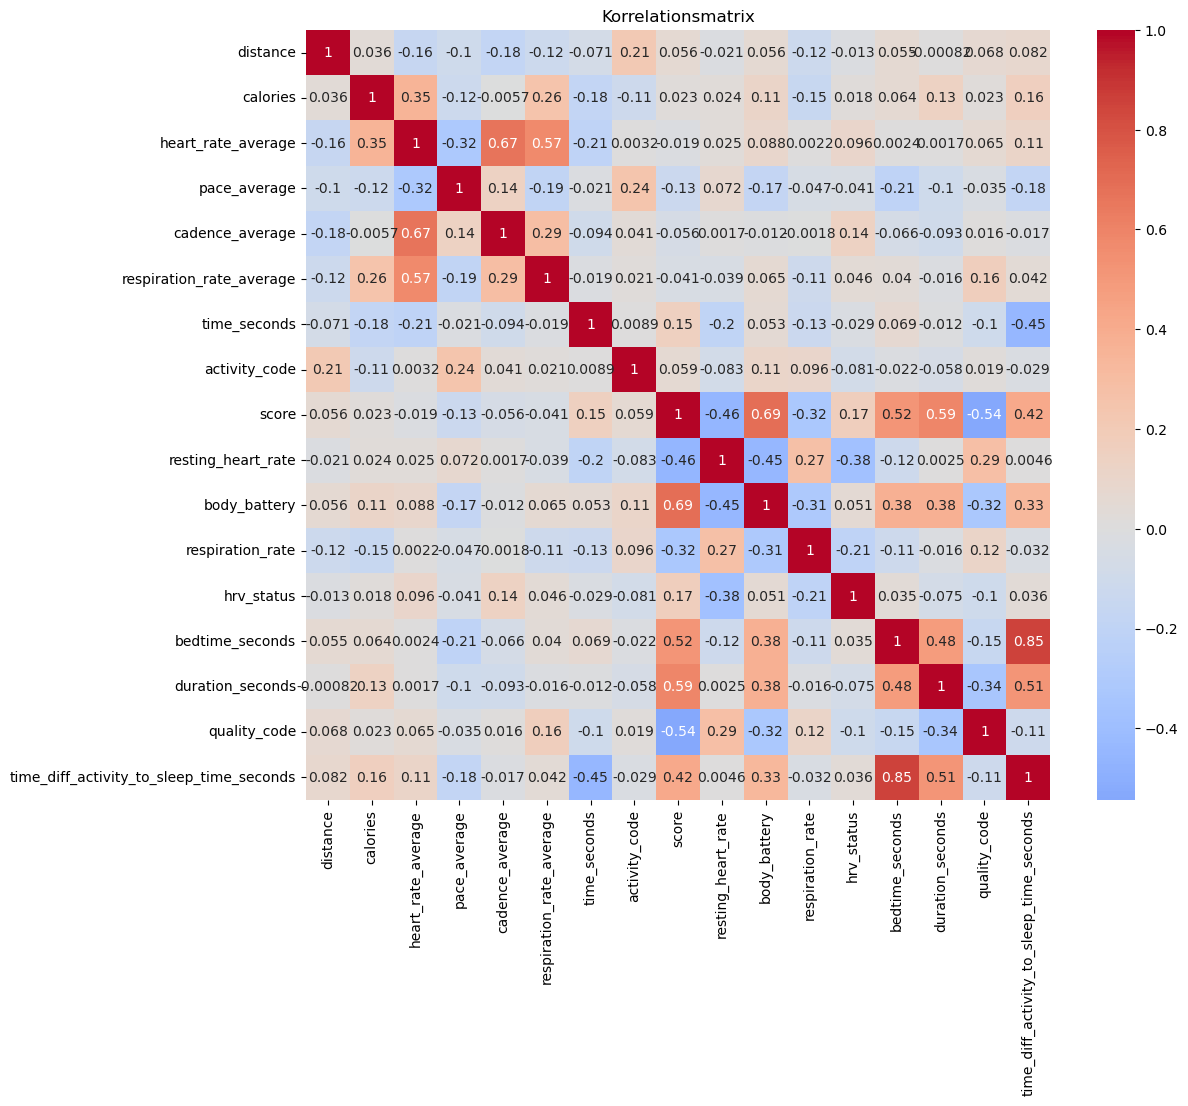

(29, 23)


In [78]:
correlation_matrix = df_combined.corr(numeric_only=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix")
plt.show()
print(filtered.shape)

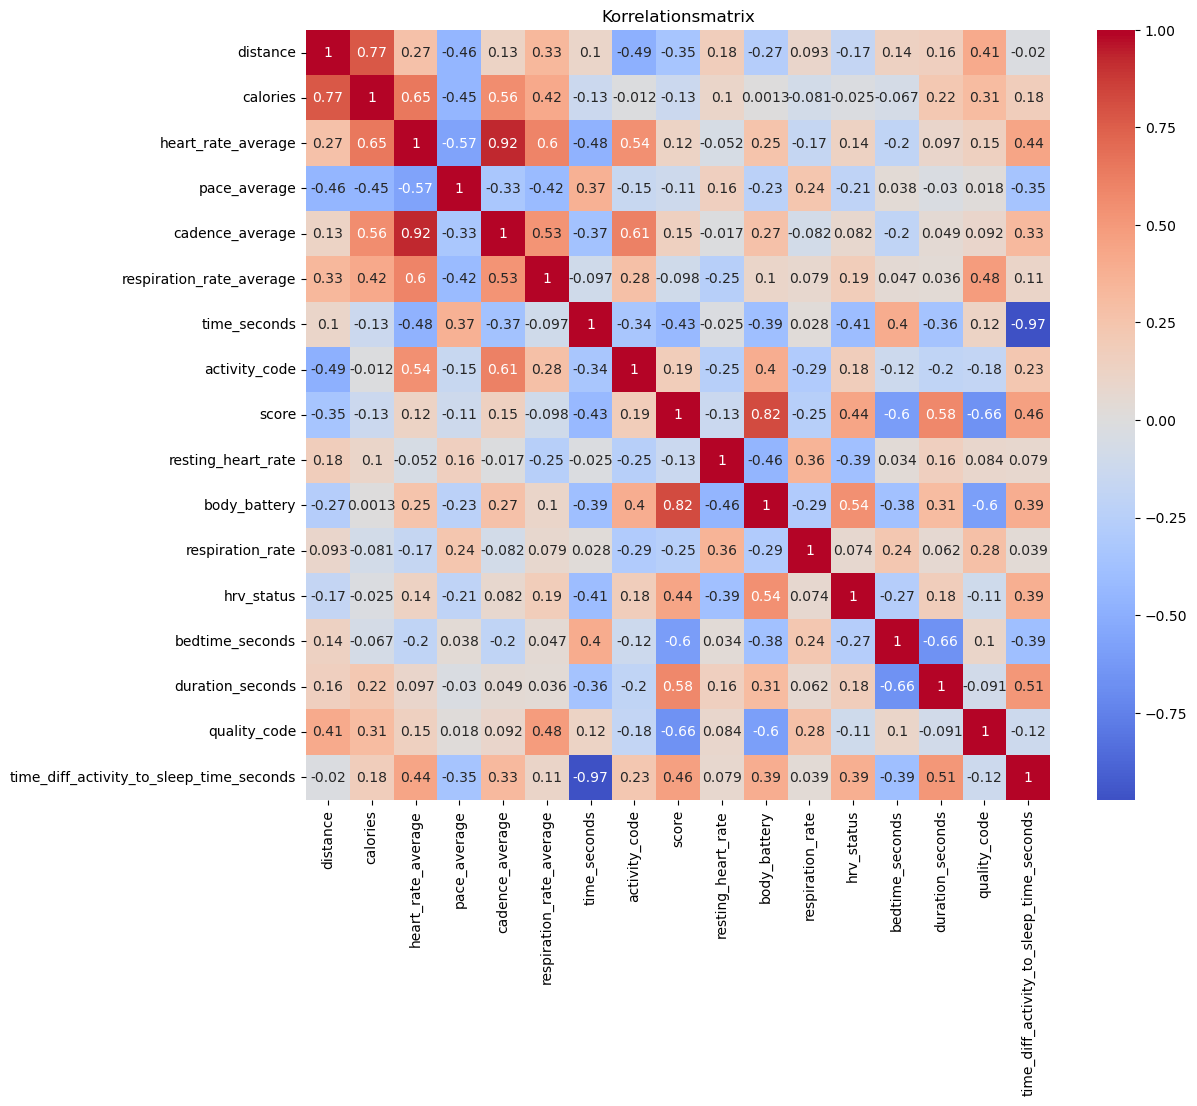

(29, 23)


In [82]:
from datetime import timedelta

df_combined = pd.merge(df_activities, df_sleep, left_on='date', right_on='date', how='inner')

if "time_seconds" in df_combined.columns and "bedtime_seconds" in df_combined.columns:
    df_combined["time_diff_activity_to_sleep_time_seconds"] = (
        df_combined["bedtime_seconds"] - df_combined["time_seconds"] + df_combined["duration_seconds"]
    )

filtered = df_combined[df_combined["time_diff_activity_to_sleep_time_seconds"] < 2 * 60 * 60]

correlation_matrix = filtered.corr(numeric_only=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix")
plt.show()
print(filtered.shape)

/var/folders/cp/r09cdjsd4hzc7p8vtlkxw48h0000gn/T/ipykernel_43237/3257245235.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


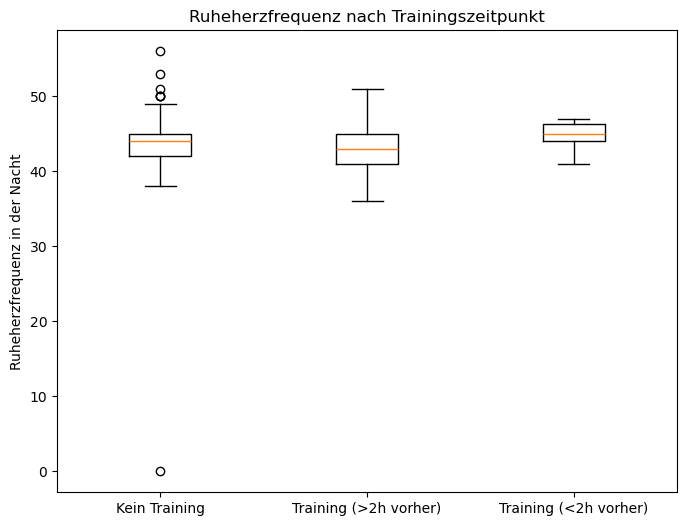

Kein Training: 114
Training (>2h vorher): 284
Training (<2h vorher): 12


/var/folders/cp/r09cdjsd4hzc7p8vtlkxw48h0000gn/T/ipykernel_43237/3257245235.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


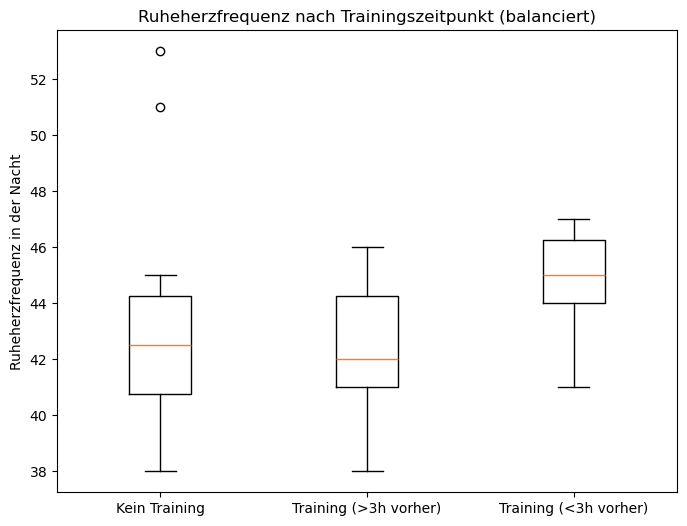

In [87]:
import matplotlib.pyplot as plt

# 1. Merge Aktivitäten und Schlafdaten
df_combined = pd.merge(df_activities, df_sleep, left_on='date', right_on='date', how='right')

if "time_seconds" in df_combined.columns and "bedtime_seconds" in df_combined.columns:
    df_combined["time_diff_activity_to_sleep_time_seconds"] = (
        df_combined["bedtime_seconds"] - df_combined["time_seconds"] + df_combined["duration_seconds"]
    )

# 2. Kennzeichne die Trainingsgruppen
df_combined['training_am_tag'] = df_combined['activity_type'].notna()
df_combined['training_2h_vor_schlaf'] = (
    (df_combined['training_am_tag']) &
    (df_combined['time_diff_activity_to_sleep_time_seconds'].abs() < 3 * 60 * 60)
)

# 3. Gruppiere die Daten
gruppe_keine_training = df_combined[df_combined['training_am_tag'] == False]['resting_heart_rate']
gruppe_training_aber_nicht_2h = df_combined[
    (df_combined['training_am_tag']) & (~df_combined['training_2h_vor_schlaf'])
]['resting_heart_rate']
gruppe_training_2h = df_combined[df_combined['training_2h_vor_schlaf']]['resting_heart_rate']

# 4. Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(
    [gruppe_keine_training.dropna(), gruppe_training_aber_nicht_2h.dropna(), gruppe_training_2h.dropna()],
    labels=['Kein Training', 'Training (>2h vorher)', 'Training (<2h vorher)']
)
plt.ylabel('Ruheherzfrequenz in der Nacht')
plt.title('Ruheherzfrequenz nach Trainingszeitpunkt')
plt.show()

print("Kein Training:", len(gruppe_keine_training.dropna()))
print("Training (>2h vorher):", len(gruppe_training_aber_nicht_2h.dropna()))
print("Training (<2h vorher):", len(gruppe_training_2h.dropna()))

# Auf die kleinste Gruppengröße beschränken
min_len = min(len(gruppe_keine_training.dropna()), len(gruppe_training_aber_nicht_2h.dropna()), len(gruppe_training_2h.dropna()))
gruppe_keine_training_balanced = gruppe_keine_training.dropna().sample(n=min_len, random_state=42)
gruppe_training_aber_nicht_2h_balanced = gruppe_training_aber_nicht_2h.dropna().sample(n=min_len, random_state=42)
gruppe_training_2h_balanced = gruppe_training_2h.dropna().sample(n=min_len, random_state=42)

# Boxplot mit balancierten Gruppen
plt.figure(figsize=(8, 6))
plt.boxplot(
    [gruppe_keine_training_balanced, gruppe_training_aber_nicht_2h_balanced, gruppe_training_2h_balanced],
    labels=['Kein Training', 'Training (>3h vorher)', 'Training (<3h vorher)']
)
plt.ylabel('Ruheherzfrequenz in der Nacht')
plt.title('Ruheherzfrequenz nach Trainingszeitpunkt (balanciert)')
plt.show()